source: https://data.world/data-society/global-climate-change-data

Import of all needed libraries:

In [4]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

getting current working directory:

In [5]:
current_directory = os.getcwd()

Reading data from files:

In [6]:
temperatures = pd.read_csv(
    os.path.join(
        current_directory,
        "GlobalLandTemperatures/GlobalLandTemperaturesByCountry2.csv"
    ),
    sep=";",
    on_bad_lines="skip"
)

by_state = pd.read_csv(
    os.path.join(
        current_directory,
        "GlobalLandTemperatures/GlobalLandTemperaturesByState2.csv"
    ),
    sep=";",
    on_bad_lines="skip"
)

by_major_city = pd.read_csv(
    os.path.join(
        current_directory,
        "GlobalLandTemperatures/GlobalLandTemperaturesByMajorCity2.csv"
    ),
    sep=";",
    on_bad_lines="skip"
)

by_country = pd.read_csv(
    os.path.join(
        current_directory,
        "GlobalLandTemperatures/GlobalLandTemperaturesByCountry2.csv"
    ),
    sep=";",
    on_bad_lines="skip"
)

Data joining in one table:

In [7]:
data = pd.concat([temperatures, by_country, by_state, by_major_city], ignore_index=True)

Reformatting date column (1 January 1750 is the start point)

In [8]:
base_date = datetime(1750, 1, 1)
data["dt"] = data["dt"].apply(lambda i: (datetime.strptime(i, "%Y-%m-%d") - base_date).days)

Reformatting string columns: Country, City, State

In [9]:
encoder = OneHotEncoder(sparse=False)

encoded_countries = encoder.fit_transform(data[["Country"]])
encoded_countries_df = pd.DataFrame(encoded_countries, columns=encoder.get_feature_names_out(["Country"]))

encoded_states = encoder.fit_transform(data[["State"]])
encoded_states_df = pd.DataFrame(encoded_states, columns=encoder.get_feature_names_out(["State"]))

encoded_cities = encoder.fit_transform(data[["City"]])
encoded_cities_df = pd.DataFrame(encoded_cities, columns=encoder.get_feature_names_out(["City"]))

data = data.drop(columns=["Country"]).join(encoded_countries_df)
data = data.drop(columns=["State"]).join(encoded_states_df)
data = data.drop(columns=["City"]).join(encoded_cities_df)

/Users/Nataliya/Desktop/university/global-climate-change/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/Nataliya/Desktop/university/global-climate-change/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/Nataliya/Desktop/university/global-climate-change/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Define the target variable and the input variables. The target variable is the `average monthly temperature`, all other values are input variables

In [10]:
x = data.drop(columns=['AverageTemperature'])
y = data['AverageTemperature']

Splitting data into train and test sets (here is `random state` set to 42, so the results are reproducible. In real life, you should not set it to any value. test_size is set to 0.3, which means that 30% of the data will be used for testing and 70% for training)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# 1. Linear regression

Create and train model

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

Test model and calculate mean squared error

In [13]:
y_pred = lin_reg.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

In [14]:
mse

53.609244824552945

Average temperature calculated by model:

In [15]:
y_pred.mean()

14.657252769047354

# 2. Gradient boosting

Create and train model

In [16]:
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(x_train, y_train)

GradientBoostingRegressor(random_state=42)

Test model and calculate mean squared error

In [17]:
y_pred_gb = gb_reg.predict(x_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)

In [18]:
mse_gb

87.41293123493541

Average temperature calculated by model:

In [19]:
y_pred_gb.mean()


14.656044562041208

## F-statistics and other classical statistical indicators for evaluating the statistical significance of regression coefficients in linear regression.

In [20]:
import statsmodels.api as sm

x_train_with_const = sm.add_constant(x_train)
lin_reg_sm = sm.OLS(y_train, x_train_with_const).fit()

In [21]:
{
    "R^2:" : lin_reg_sm.rsquared,
    "F-статистика:" : lin_reg_sm.fvalue,
    "AIC:" : lin_reg_sm.aic,
    "BIC:" : lin_reg_sm.bic,
    "Регульований R-квадрат:" : lin_reg_sm.rsquared_adj,
    "Обсяг вибірки:" : lin_reg_sm.nobs,
    "Кількість незалежних змінних:" : lin_reg_sm.df_model,
    "Кількість спостережень:" : lin_reg_sm.df_resid,
}

{'R^2:': 0.655434650379366,
 'F-статистика:': 4416.413477669926,
 'AIC:': 9249327.251874978,
 'BIC:': 9256417.686295202,
 'Регульований R-квадрат:': 0.6552862415735119,
 'Обсяг вибірки:': 1356476.0,
 'Кількість незалежних змінних:': 584.0,
 'Кількість спостережень:': 1355891.0}

## Error Distribution Visualization: Compare the error distributions for both models to see which model has the smaller error spread.

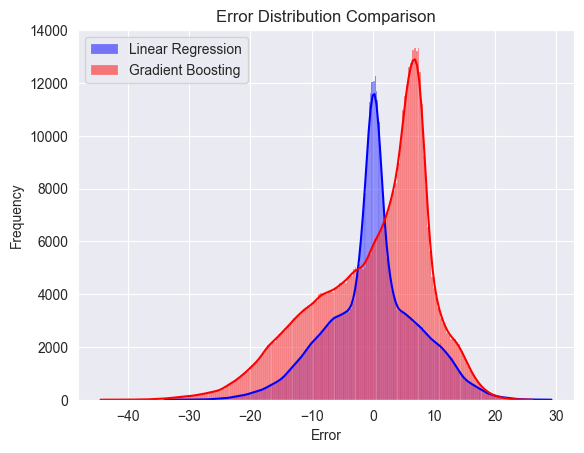

In [22]:
errors_lin = y_test - y_pred
errors_gb = y_test - y_pred_gb

sns.histplot(errors_lin, kde=True, color='blue', alpha=0.5, label='Linear Regression')
sns.histplot(errors_gb, kde=True, color='red', alpha=0.5, label='Gradient Boosting')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error Distribution Comparison')
plt.show()

## Calculation of various metrics such as mean squared error (MSE), mean absolute error (MAE), and coefficient of determination R^2 for each model.

In [23]:
from sklearn.metrics import mean_absolute_error, r2_score

# Linear regression
mae_lin = mean_absolute_error(y_test, y_pred)
r2_lin = r2_score(y_test, y_pred)

# Gradient boosting
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Linear regression:")
print(f"Mean squared error: {mse:.4f}")
print(f"Mean absolute error: {mae_lin:.4f}")
print(f"Coefficient of determination R^2: {r2_lin:.4f}")

print("\nGradient boosting:")
print(f"RMS: {mse_gb:.4f}")
print(f"Mean absolute error: {mae_gb:.4f}")
print(f"Coefficient of determination R^2: {r2_gb:.4f}")


Linear regression:
Mean squared error: 53.6092
Mean absolute error: 5.4165
Coefficient of determination R^2: 0.6547

Gradient boosting:
RMS: 87.4129
Mean absolute error: 7.6495
Coefficient of determination R^2: 0.4370


## Visualization of actual values and predictions for both models on the same graph.

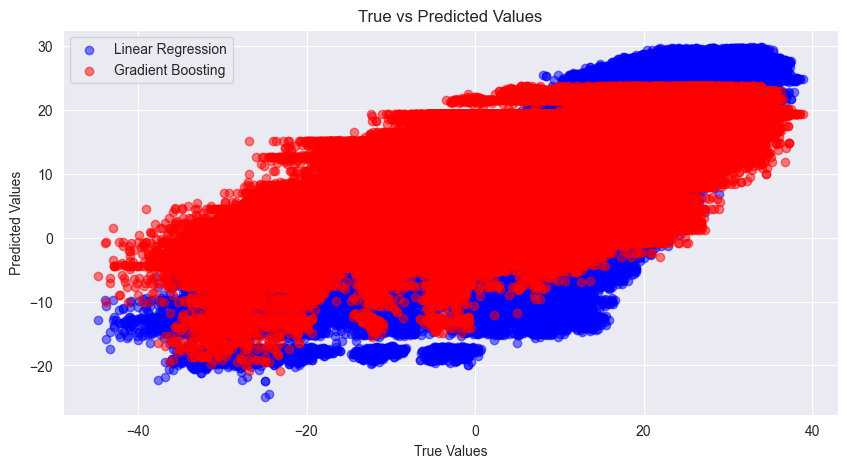

In [24]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Linear Regression')
plt.scatter(y_test, y_pred_gb, alpha=0.5, color='red', label='Gradient Boosting')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.show()


## Distribution of average temperature in the data

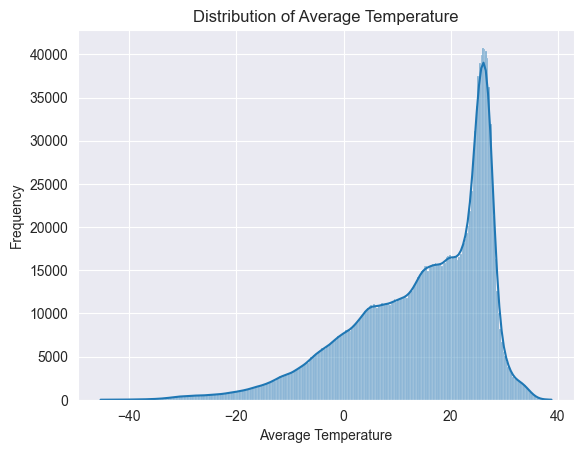

In [25]:
sns.histplot(data['AverageTemperature'], kde=True)
plt.xlabel('Average Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Average Temperature')
plt.show()

## Difference between predictions of the two models


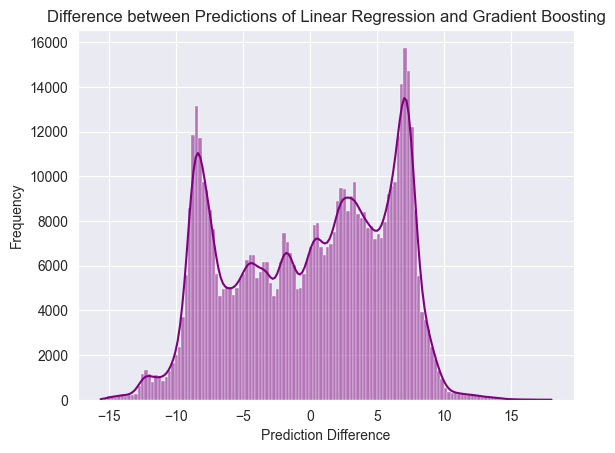

In [26]:
prediction_difference = y_pred - y_pred_gb

sns.histplot(prediction_difference, kde=True, color='purple')
plt.xlabel('Prediction Difference')
plt.ylabel('Frequency')
plt.title('Difference between Predictions of Linear Regression and Gradient Boosting')
plt.show()

## Temperature predictions for a random sample of points

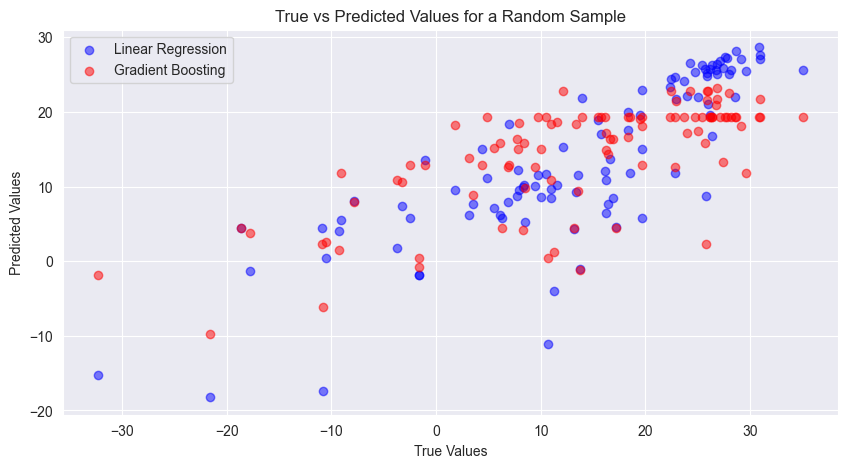

In [28]:
import numpy as np

sample_indices = np.random.choice(x_test.index, size=100, replace=False)
sample_x_test = x_test.loc[sample_indices]
sample_y_test = y_test.loc[sample_indices]

sample_y_pred_lin = lin_reg.predict(sample_x_test)
sample_y_pred_gb = gb_reg.predict(sample_x_test)

plt.figure(figsize=(10, 5))
plt.scatter(sample_y_test, sample_y_pred_lin, alpha=0.5, color='blue', label='Linear Regression')
plt.scatter(sample_y_test, sample_y_pred_gb, alpha=0.5, color='red', label='Gradient Boosting')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('True vs Predicted Values for a Random Sample')
plt.show()


## Errors of linear regression and gradient boosting relative to true values

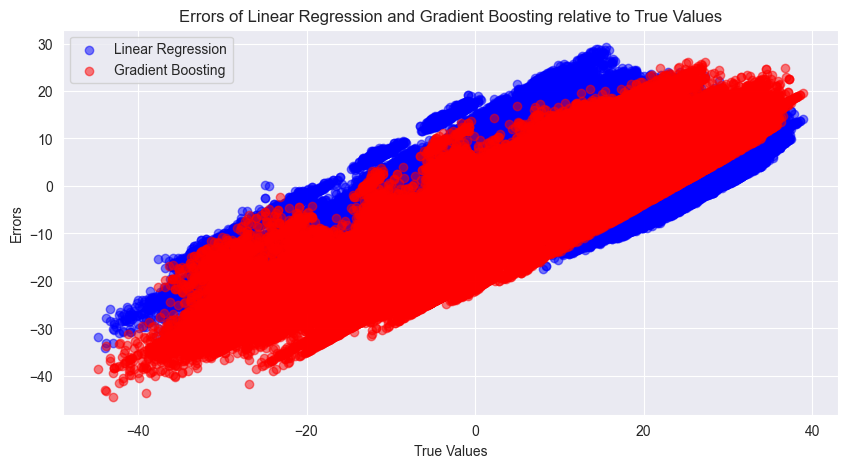

In [29]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, errors_lin, alpha=0.5, color='blue', label='Linear Regression')
plt.scatter(y_test, errors_gb, alpha=0.5, color='red', label='Gradient Boosting')
plt.xlabel('True Values')
plt.ylabel('Errors')
plt.legend()
plt.title('Errors of Linear Regression and Gradient Boosting relative to True Values')
plt.show()


## Ratio of prediction errors to true temperatures for both models


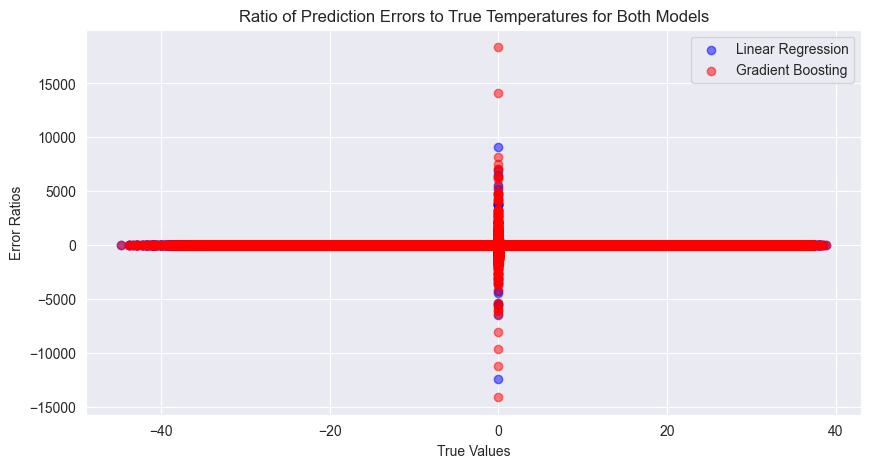

In [30]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, errors_lin / y_test, alpha=0.5, color='blue', label='Linear Regression')
plt.scatter(y_test, errors_gb / y_test, alpha=0.5, color='red', label='Gradient Boosting')
plt.xlabel('True Values')
plt.ylabel('Error Ratios')
plt.legend()
plt.title('Ratio of Prediction Errors to True Temperatures for Both Models')
plt.show()
